In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('performance.csv')

In [39]:
NEW_INJECTION_EPISODE = 95
CONVERGENCE_THRESHOLD = 1.5
shops = ['shop_1', 'shop_2', 'shop_3', 'shop_4','shop_5','shop_6','shop_7','shop_8','shop_9','shop_10']
shops_group1 = ['shop_1', 'shop_2','shop_3', 'shop_4', 'shop_10']
shops_group2 = ['shop_5', 'shop_6','shop_7', 'shop_8', 'shop_9']
def episodes_to_convergence(df: pd.DataFrame, starting_episode):
    df.index = df['episodes']
    means = df[shops_group1].mean(axis=1).rolling(5).mean()
    means = means.loc[starting_episode:][means < CONVERGENCE_THRESHOLD]
    if len(means) == 0:
        return 200
    return means.index[0]
def jumpstart_performance(df: pd.DataFrame, starting_episode, first_n_episodes_to_consider=5):
    df.index = df['episodes']
    return df[shops_group1].loc[starting_episode:starting_episode+first_n_episodes_to_consider].mean().mean()

def transfer_ratio(df: pd.DataFrame):
    initial_convergence = episodes_to_convergence(df, 1)
    after_knowledge_transfer_convergence = episodes_to_convergence(df, 100)
    return after_knowledge_transfer_convergence / initial_convergence

    

In [42]:
s = ['off_policy_factor','transfer_strategy','off_policy_loss_cat','retrain_cat','n_retrain','batch_size','sampling','use_exploration']
grouped = data.groupby(['off_policy_factor', 'transfer_strategy', 'off_policy_loss_cat', 'retrain_cat', 'n_retrain', 'batch_size', 'sampling', 'use_exploration'])
results = []
for index, group in grouped:
    result = dict((x, y) for x, y in zip(s, index))
    result['episodes_to_convergence'] = episodes_to_convergence(group, 100)
    result['jumpstart_performance_after_conv'] = jumpstart_performance(group, 95)
    result['transfer_ratio'] = transfer_ratio(group)
    results.append(result)
df = pd.DataFrame.from_records(results)
    
    

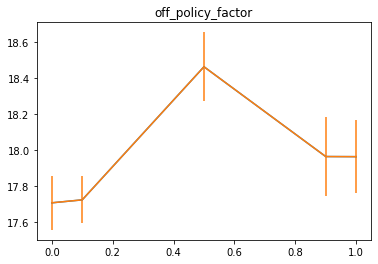

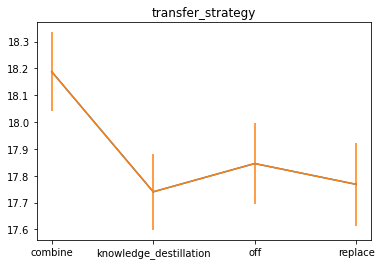

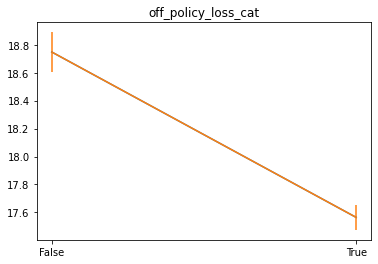

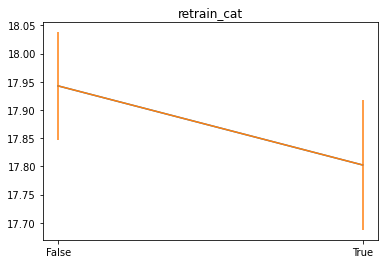

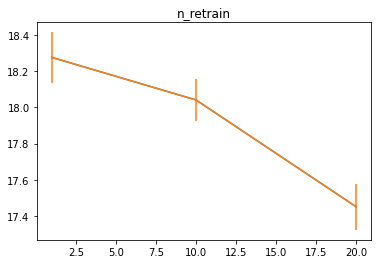

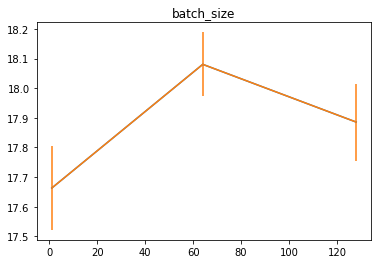

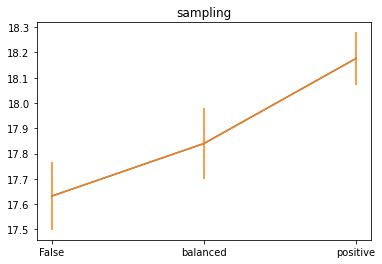

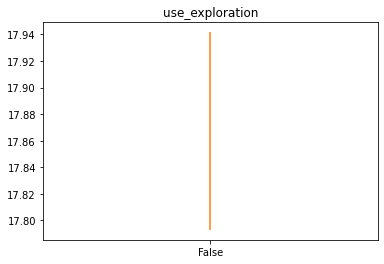

In [43]:


def inversed_quantile(df: pd.DataFrame, columnName, quantile, mode):
    if isinstance(df, pd.Series):
        df = df.sort_values(ascending=False)
    else:
        df =df.sort_values(columnName, ascending=False)
    return df.iloc[int(quantile*len(df)):].mean() if mode=='mean' else df.iloc[int(quantile*len(df)):].sem()

def plot_effect_of_hyperparameters(df: pd.DataFrame, metric: str):
    df.sort_values(metric)
    for el in s:
        performance_data_mean = df[df['use_exploration']==False][[el, metric]].groupby(el).aggregate(lambda x :inversed_quantile(x, metric, 0.9, mode='mean')).reset_index()
        performance_data_variance = df[df['use_exploration']==False][[el, metric]].groupby(el).aggregate(lambda x :inversed_quantile(x, metric, 0.9, mode='variance')).reset_index()

        plt.plot(performance_data_mean[el], performance_data_mean[metric])
        plt.errorbar(performance_data_mean[el], performance_data_mean[metric], yerr=performance_data_variance[metric])

        if isinstance(performance_data_mean[el][0], (str, np.bool_)):
            plt.xticks(range(len(performance_data_mean[el])), performance_data_mean[el])
        plt.title(el)
        plt.show()
plot_effect_of_hyperparameters(df, 'jumpstart_performance_after_conv')

In [ ]:
def calculate_real_jumpstart():
    